In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.layers import Dense, Activation, Dropout
import time #helper libraries

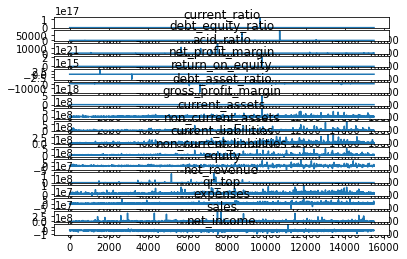

In [2]:
# load dataset
dataset = read_csv('../Features/all_data.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [i for i in range(17)]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='center')
	i += 1
plt.show()

In [3]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
path = '../Features/all_data.csv'
dataset = pd.read_csv(path, index_col=[0])
dataset.head()


,current_ratio,debt_equity_ratio,acid_ratio,net_profit_margin,return_on_equity,debt_asset_ratio,gross_profit_margin,current_assets,non_current_assets,current_liabilities,non_current_liabilities,equity,net_revenue,qr_top,expenses,sales,net_income
date,,,,,,,,,,,,,,,,,
1996,0.000000,-1.000000,0.000000,0.0,1.000000,0.000000,0.0,0.00,0.00,168.05,0.00,-168.05,0.0,0.0,0.00,0.0,-168.05
1997,8.868155,1.421096,1.558577,0.0,-0.155355,0.586964,0.0,256149.91,132453.74,28884.24,199212.08,160507.33,0.0,45018.3,49228.65,0.0,-24935.66
1997,1.552933,0.396801,0.575363,0.0,0.007962,0.284079,0.0,58137.47,101808.48,37437.21,8000.00,114508.74,0.0,21540.0,17692.65,0.0,911.70
1997,0.000000,-1.000000,0.000000,0.0,-0.000000,0.000000,0.0,0.00,0.00,403.32,0.00,-403.32,0.0,0.0,0.00,0.0,0.00
1998,1.896844,-6.234112,1.111071,0.0,1.115381,1.191054,0.0,1580511.97,65357.05,833232.24,1127087.26,-314450.48,0.0,925780.1,453328.22,0.0,-350731.97


In [26]:
values = dataset.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
# frame as supervised learning
reframed = series_to_supervised(values, 2, 1)
reframed = scaler.fit_transform(reframed)


reframed = pd.DataFrame(reframed)
# drop columns we don't want to predict
print(reframed.head())

             0         1         2             3         4         5   \
0  5.647950e-12  0.015462  0.034113  4.148037e-11  0.517494  0.865470   
1  5.648024e-12  0.015490  0.034197  4.148037e-11  0.517494  0.865497   
2  5.647963e-12  0.015479  0.034144  4.148037e-11  0.517494  0.865483   
3  5.647950e-12  0.015462  0.034113  4.148037e-11  0.517494  0.865470   
4  5.647965e-12  0.015402  0.034173  4.148037e-11  0.517494  0.865526   

         6         7         8         9   ...        41        42        43  \
0  0.049173  0.142465  0.045261  0.060054  ...  0.142543  0.045398  0.060144   
1  0.049173  0.142809  0.045439  0.060123  ...  0.142465  0.045261  0.060054   
2  0.049173  0.142543  0.045398  0.060144  ...  0.144591  0.045349  0.062067   
3  0.049173  0.142465  0.045261  0.060054  ...  0.142465  0.045261  0.060054   
4  0.049173  0.144591  0.045349  0.062067  ...  0.142918  0.045802  0.060771   

         44        45   46        47        48        49        50  
0  0.179218

In [27]:
values = reframed.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
# filler = np.array([0]*12386)
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# train_X = np.append(train_X, np.zeros([len(train_X), 1]), 1)
# test_X = np.append(test_X, np.zeros([len(test_X), 1]), 1)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(12384, 1, 50) (12384,) (3097, 1, 50) (3097,)


In [28]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

Epoch 1/150
194/194 - 6s - loss: 0.0064 - val_loss: 4.4312e-04
Epoch 2/150
194/194 - 1s - loss: 4.7668e-04 - val_loss: 3.9155e-04
Epoch 3/150
194/194 - 0s - loss: 4.5110e-04 - val_loss: 3.5658e-04
Epoch 4/150
194/194 - 0s - loss: 4.3164e-04 - val_loss: 3.3458e-04
Epoch 5/150
194/194 - 1s - loss: 4.1855e-04 - val_loss: 3.2186e-04
Epoch 6/150
194/194 - 1s - loss: 4.1023e-04 - val_loss: 3.1520e-04
Epoch 7/150
194/194 - 1s - loss: 4.0509e-04 - val_loss: 3.1269e-04
Epoch 8/150
194/194 - 1s - loss: 4.0189e-04 - val_loss: 3.1387e-04
Epoch 9/150
194/194 - 1s - loss: 3.9986e-04 - val_loss: 3.1653e-04
Epoch 10/150
194/194 - 1s - loss: 3.9703e-04 - val_loss: 3.0938e-04
Epoch 11/150
194/194 - 1s - loss: 3.9410e-04 - val_loss: 3.0334e-04
Epoch 12/150
194/194 - 1s - loss: 3.9129e-04 - val_loss: 3.0133e-04
Epoch 13/150
194/194 - 1s - loss: 3.8948e-04 - val_loss: 2.9980e-04
Epoch 14/150
194/194 - 1s - loss: 3.8820e-04 - val_loss: 2.9926e-04
Epoch 15/150
194/194 - 1s - loss: 3.8764e-04 - val_loss: 3.00

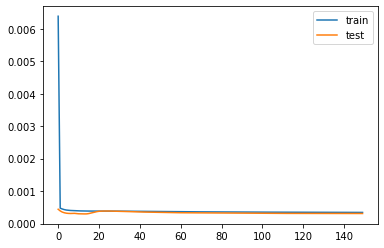

In [29]:
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [30]:
from numpy import concatenate
import tensorflow
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

test_X = tf.squeeze(test_X)
test_X = tf.expand_dims(test_X, axis=1)
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast

inv_yhat = concatenate((test_X[:,:], yhat), axis=1)
print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :], test_y), axis=1)

inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

# calculate RMSE
# inv_y = [el/10**16 for el in inv_y]
# inv_yhat = [el/10**16 for el in inv_yhat]

rmse = np.sqrt(mean_absolute_error(inv_y, inv_yhat))
print('Test MAE: %.3f' % rmse)

(3097, 51)
Test MAE: 1580.211


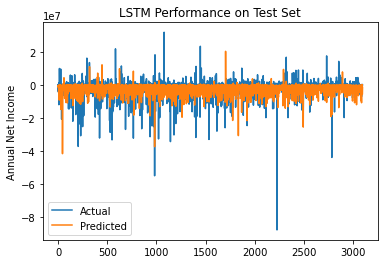

In [35]:
plt.title("LSTM Performance on Test Set")
plt.plot(inv_y, label="Actual")
plt.plot(inv_yhat, label="Predicted")
plt.ylabel("Annual Net Income")
plt.legend()